<a href="https://colab.research.google.com/github/AyozeGS/Maze/blob/main/Maze_Random_with_BFS_DFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diseño del laberinto



In [7]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LinearSegmentedColormap

#Define functions

#Define class Place with coordinates row,col
class Place():
  def __init__(self, row=1, col=1):
    self.row = row
    self.col = col

#Define class Displacement with axis x,y
class Displacement():
  def __init__(self,x=0,y=0):
    self.x = x
    self.y = y
  def apply_to(self, place:Place):
    new_row = place.row + self.x
    new_col = place.col + self.y
    return Place(new_row, new_col)

#Define class Agent with his position
class Agent():
  def __init__(self, place=Place()):
    self.place = place
  def teleport(self, place):
    self.place = place
  def move(self, moves, direction):
    displacement = Displacement(moves[direction][0], moves[direction][1])
    self.place = displacement.apply_to(self.place)
  def check_move(self, moves, direction):
    displacement = Displacement(moves[direction][0], moves[direction][1])
    return displacement.apply_to(self.place)

#Define function empty_maze, an empty space rounded of  walls.
def empty_maze(h, w, v_empty, v_wall, v_init, v_goal, init_place, end_place):
  def wall(n, v_wall):
    return np.ones([1,n], dtype=int)*v_wall
  maze = np.ones([h-2, w-2], dtype=int)*v_empty
  maze = np.concatenate([wall(h-2,v_wall).T, maze, wall(h-2,v_wall).T], axis=1)
  maze = np.concatenate([wall(w,v_wall), maze, wall(w,v_wall)], axis=0)
  maze[init_place.row, init_place.col] = v_init
  maze[end_place.row, end_place.col] = v_goal
  return maze

#Random maze
def add_random_maze(maze_empty, v_wall, v_empty, init_place, end_place):
  moves_directions= np.array([[-1,0],[0,1],[1,0],[0,-1]])
  check_directions = np.array([[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]])
  mark = np.copy(maze_empty)
  agent = Agent(Place(init_place.row,init_place.col))
  possible_directions = []
  alternative_available = [agent.place]
  direction = 0
  v_aux = -1

  #fill with v_aux
  for row in range(1,maze.shape[0]-1):
    for col in range(1,maze.shape[1]-1):
      if (row != init_place.row or col != init_place.col) and (row != end_place.row or col != end_place.col):
        mark[row,col] = v_aux

  #from current cell, choose one random direction and add new cell to list of nodes for new  paths
  while alternative_available:
    possible_directions.clear()
    #check free directions
    for i in range(moves_directions.shape[0]):
      adj_place = agent.check_move(moves_directions,i)
      if mark[adj_place.row, adj_place.col] == v_aux:
        possible_directions.append(i)
    #if two or more directions available save node to list
    if len(possible_directions) > 0:
      alternative_available.append(agent.place)
    #if no directions available teleport to random node in the list and remove it from it
    if not possible_directions:
      agent.teleport(random.choice(alternative_available))
      alternative_available.remove(agent.place)
    #move to random direction and mark it like empty
    else:
      new_direction = random.choice(possible_directions)
      agent.move(moves_directions, new_direction)
      mark[agent.place.row, agent.place.col] = v_empty
      #check 5 cells adjacents in the opposite side form previous position
      rolled_check_directions = np.roll(check_directions, (((new_direction*2)-2)*-2))
      for i in range(check_directions.shape[0]-3):
        adj_place = agent.check_move(rolled_check_directions,i)
        #if there is an empty cell adjacent to current change current to wall and telepor to random node in the list
        if mark[adj_place.row, adj_place.col] == v_empty:
          mark[agent.place.row, agent.place.col] = v_wall
          agent.teleport(random.choice(alternative_available))
          alternative_available.remove(agent.place)
          break;

  #fix v_aux to walls
  for row in range(1,maze.shape[0]-1):
    for col in range(1,maze.shape[1]-1):
      if mark[row,col] == v_aux:
        mark[row,col] = v_wall

  return mark

## Algoritmos BFS y DFS

In [8]:
#Resolve maze using breadth first search algorithm and filling visited cells with incremental values.
#Need maze matrix, moves matrix, and initial and final points,
def breadth_first_search(maze:np.ndarray, moves:np.ndarray, init:Place, goal:Place):
  mark = np.copy(maze)
  agent = Agent(init)
  fifo = [init]
  move_index = 1
  is_goal_reached = False
  is_queue_empty = False

  #Check adjacents cells and add to FIFO those not visited
  def search_adjacents_places():
    nonlocal move_index
    #teleport agent to the current square and check cells resulting from the movements
    for i in range(moves.shape[0]):
      adj_place = agent.check_move(moves,i)
      if mark[adj_place.row, adj_place.col] == VALUE_GOAL:
        print("Ha alcanzado la meta en", move_index, "movimientos!!")
        return True
      elif mark[adj_place.row, adj_place.col] == VALUE_EMPTY:
        fifo.append(adj_place)
        mark[adj_place.row, adj_place.col]=move_index*value_offset_step+VALUE_OFFSET_MIN
        move_index += 1
    return False;

  #check adjacentes of all cells added to queue (fifo) until find the goal
  while (not is_goal_reached) and (not is_queue_empty):
    agent.teleport(fifo.pop(0))
    is_goal_reached = search_adjacents_places()
    #check empty queue
    if not fifo:
      print("No ha encontrado la salida.")
      is_queue_empty = True

  return mark

#Resolve maze using depth first search algorithm and filling visited cells with incremental values.
#Need maze matrix, moves matrix, and initial and final points,
def depth_first_search(maze:np.ndarray, moves:np.ndarray, init:Place, goal:Place):
  mark = np.copy(maze)
  agent = Agent(init)
  stack = [init]
  move_index = 1

  #Move to directions one by one trying differents routes
  def check_next_direction():
    nonlocal move_index
    for i in range(moves.shape[0]):
      #check cell resulting from the movements
      adj_place = agent.check_move(moves,i)
      if mark[adj_place.row, adj_place.col] == VALUE_GOAL:
        return True
      elif mark[adj_place.row, adj_place.col] == VALUE_EMPTY:
        #move to first empty cell found and add it to stack (LIFO)
        agent.move(moves,i)
        stack.append(adj_place)
        mark[adj_place.row, adj_place.col]=move_index*value_offset_step+VALUE_OFFSET_MIN
        move_index += 1
        #check movements from the new position.
        if check_next_direction():
          return True
        #If no path, back to the previous one and delete cell from stack (LIFO)
        agent.move(moves*-1,i)
        stack.pop()
    return False;

  if check_next_direction():
    print("Ha alcanzado la meta en", move_index, "movimientos!!")
  else:
    print("No ha encontrado la salida.")

  mark_solution = np.copy(maze)
  for place in stack[1:]:
    mark_solution[place.row, place.col] = VALUE_OFFSET_MAX+value_offset_step

  return mark, mark_solution

## Preparación del laberinto

In [13]:
#MAZE PARAMETERS TO CONFIGURE
height=50
width=50
init_row = 1
init_col = 1
goal_row = height-2
goal_col = width-2

#SHOW PARAMETERS TO CONFIGURE
fig_width = 4*width/10
fig_height = 3*height/10

#Spacecolor parameters
# Grey(1) -> White(1.5) -> Orange(2) -> Purple(2.5) -> Green(3)
COLORS = [(.7,.7,.7), (1,1,1), (1,.5,0), (0.5,0,0.5), (0,1,0)]
VALUE_WALL = 1
VALUE_EMPTY = 1.5
VALUE_INIT = 2
VALUE_GOAL = 3
VALUE_OFFSET_MAX=2.9
VALUE_OFFSET_MIN=2.1

#Moves matrix
MOVES4 = np.array([[-1,0],[0,1],[1,0],[0,-1]])
MOVES8 = np.array([[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]])

#Other vars
start_position = Place(init_row, init_col)
goal_position = Place(goal_row, goal_col)
cmap = LinearSegmentedColormap.from_list('maze', COLORS, N=height*width*3)
value_offset_step = (VALUE_OFFSET_MAX-VALUE_OFFSET_MIN)/((height-2)*(width-2))

#Function for visualizate mazes
def visualize_example(maze, ax, title, show_colorbar=False):
  im = ax.imshow(maze, cmap=cmap)
  ax.set_title(title)
  ax.axis(False)
  if show_colorbar:
    plt.colorbar(im, ax=ax, fraction=0.046)
  for (i,j),label in np.ndenumerate(maze):
    if maze[i][j] <= VALUE_OFFSET_MAX and maze[i][j] >= VALUE_OFFSET_MIN:
      ax.text(j,i,int(round((label-VALUE_OFFSET_MIN)/value_offset_step)),ha='center',va='center')

## Creación del laberinto

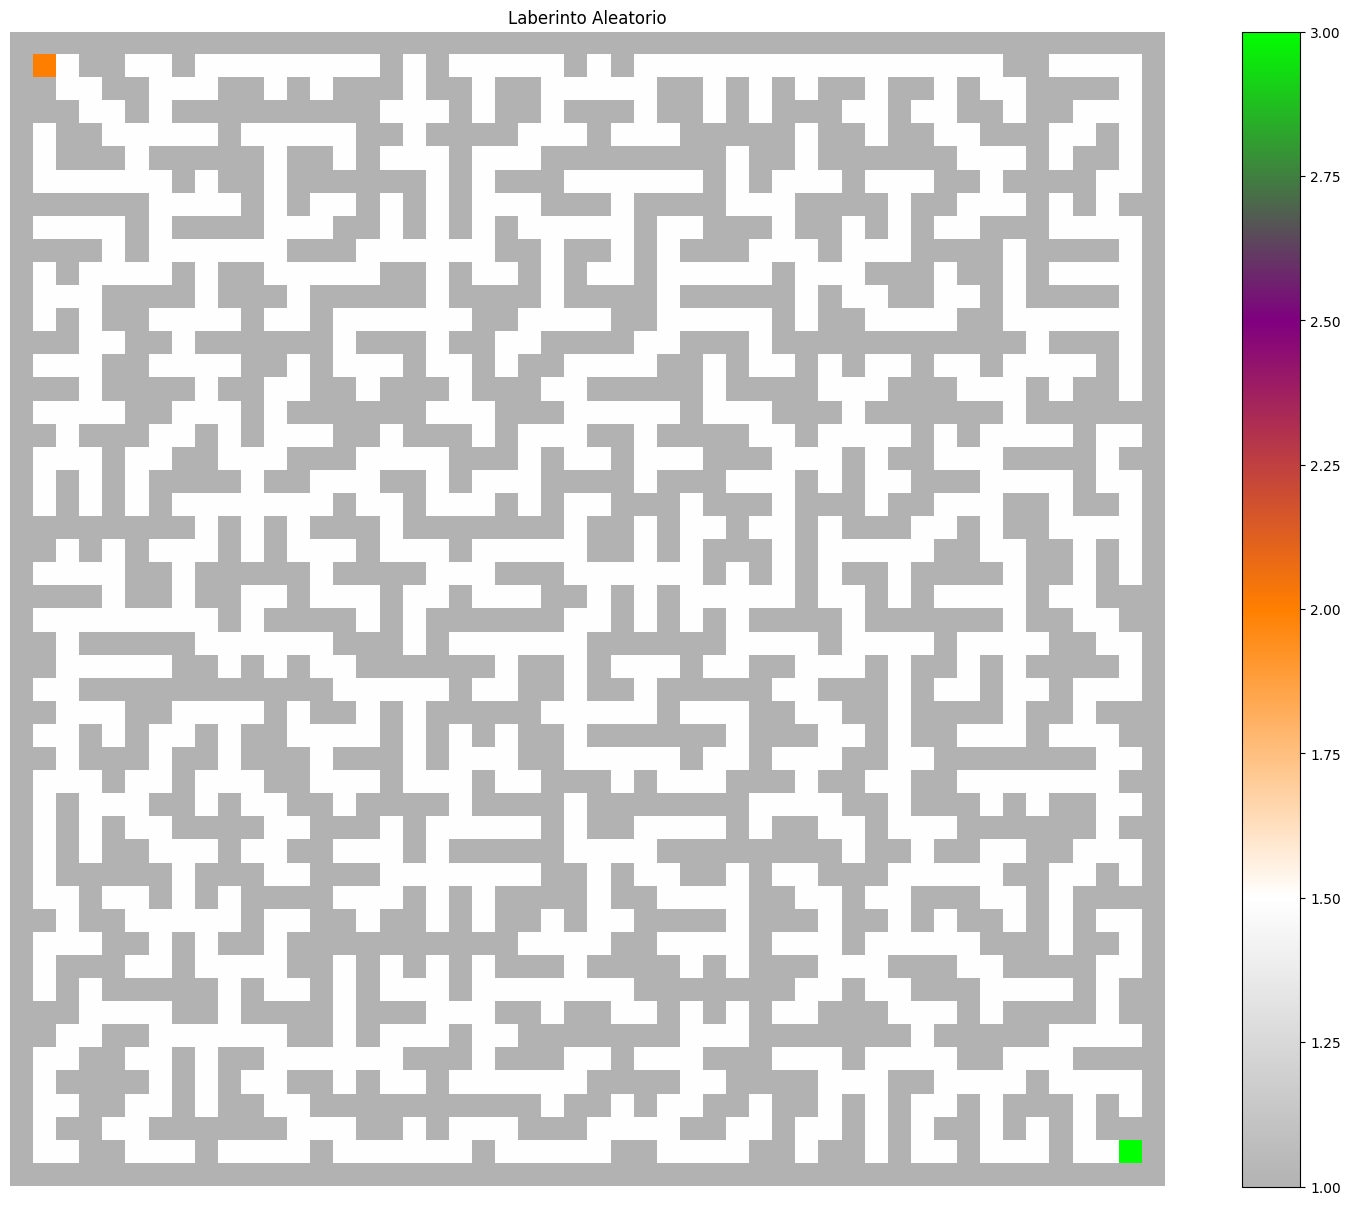

In [14]:
## Create mazes

#Create empty maze with init and end points
maze = empty_maze(height, width, VALUE_EMPTY, VALUE_WALL, VALUE_INIT, VALUE_GOAL, start_position, goal_position)
maze_random = add_random_maze(maze, VALUE_WALL, VALUE_EMPTY, start_position, goal_position)

fig, ax = plt.subplots(1,1, figsize=(fig_width,fig_height))
visualize_example(maze_random,ax,'Laberinto Aleatorio', True)


## Resolución con algoritmos

Ha alcanzado la meta en 1125 movimientos!!


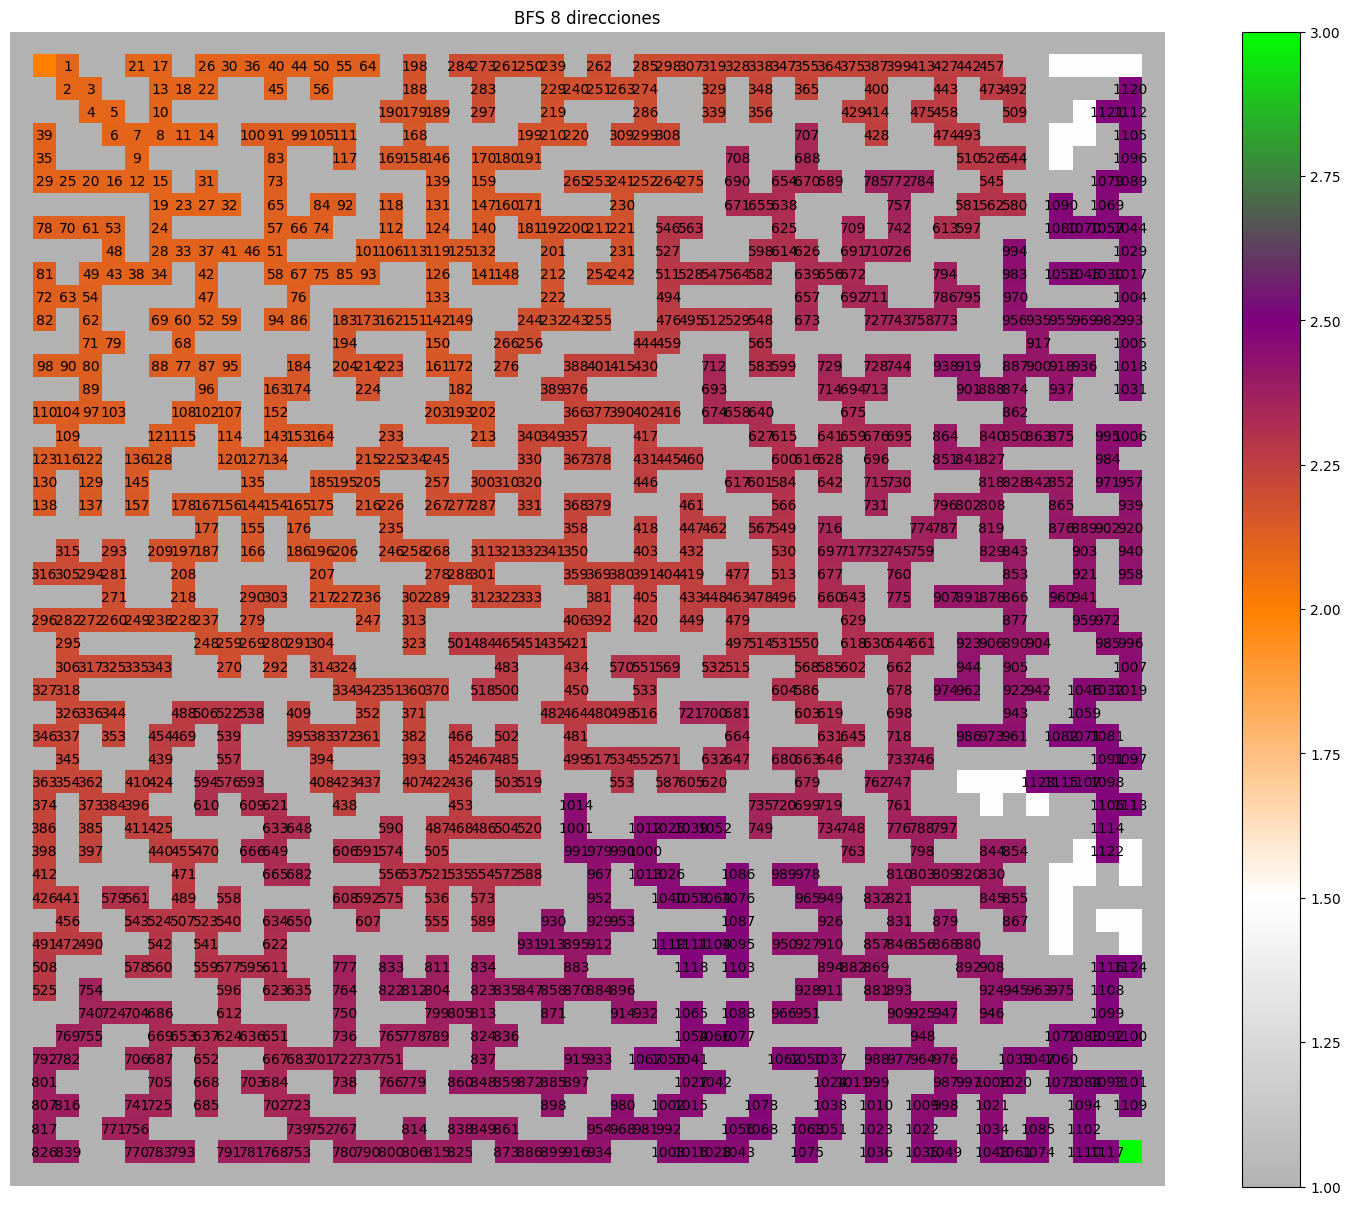

In [16]:
mark = breadth_first_search(maze_random, MOVES4, start_position, goal_position)

fig, ax = plt.subplots(1,1, figsize=(fig_width,fig_height))
visualize_example(mark,ax,'BFS 8 direcciones', True)

Ha alcanzado la meta en 618 movimientos!!


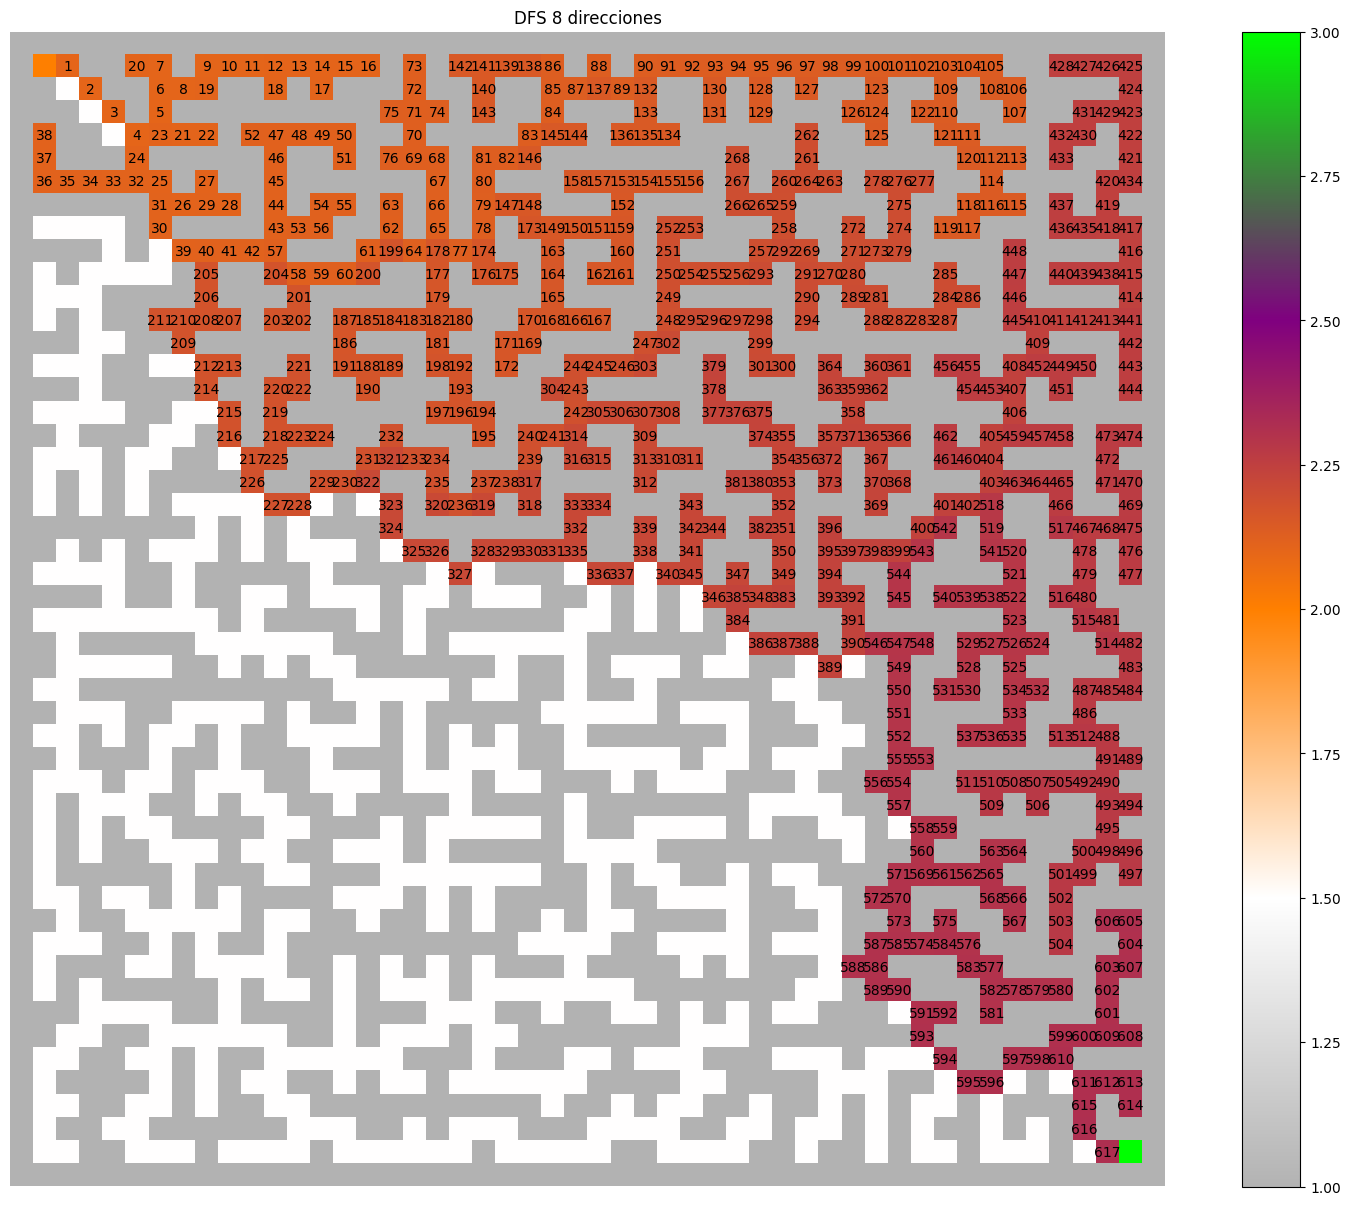

In [18]:
mark, mark_solution = depth_first_search(maze_random, MOVES8, start_position, goal_position)

fig, ax = plt.subplots(1,1, figsize=(fig_width,fig_height))
visualize_example(mark,ax,'DFS 8 direcciones', True)

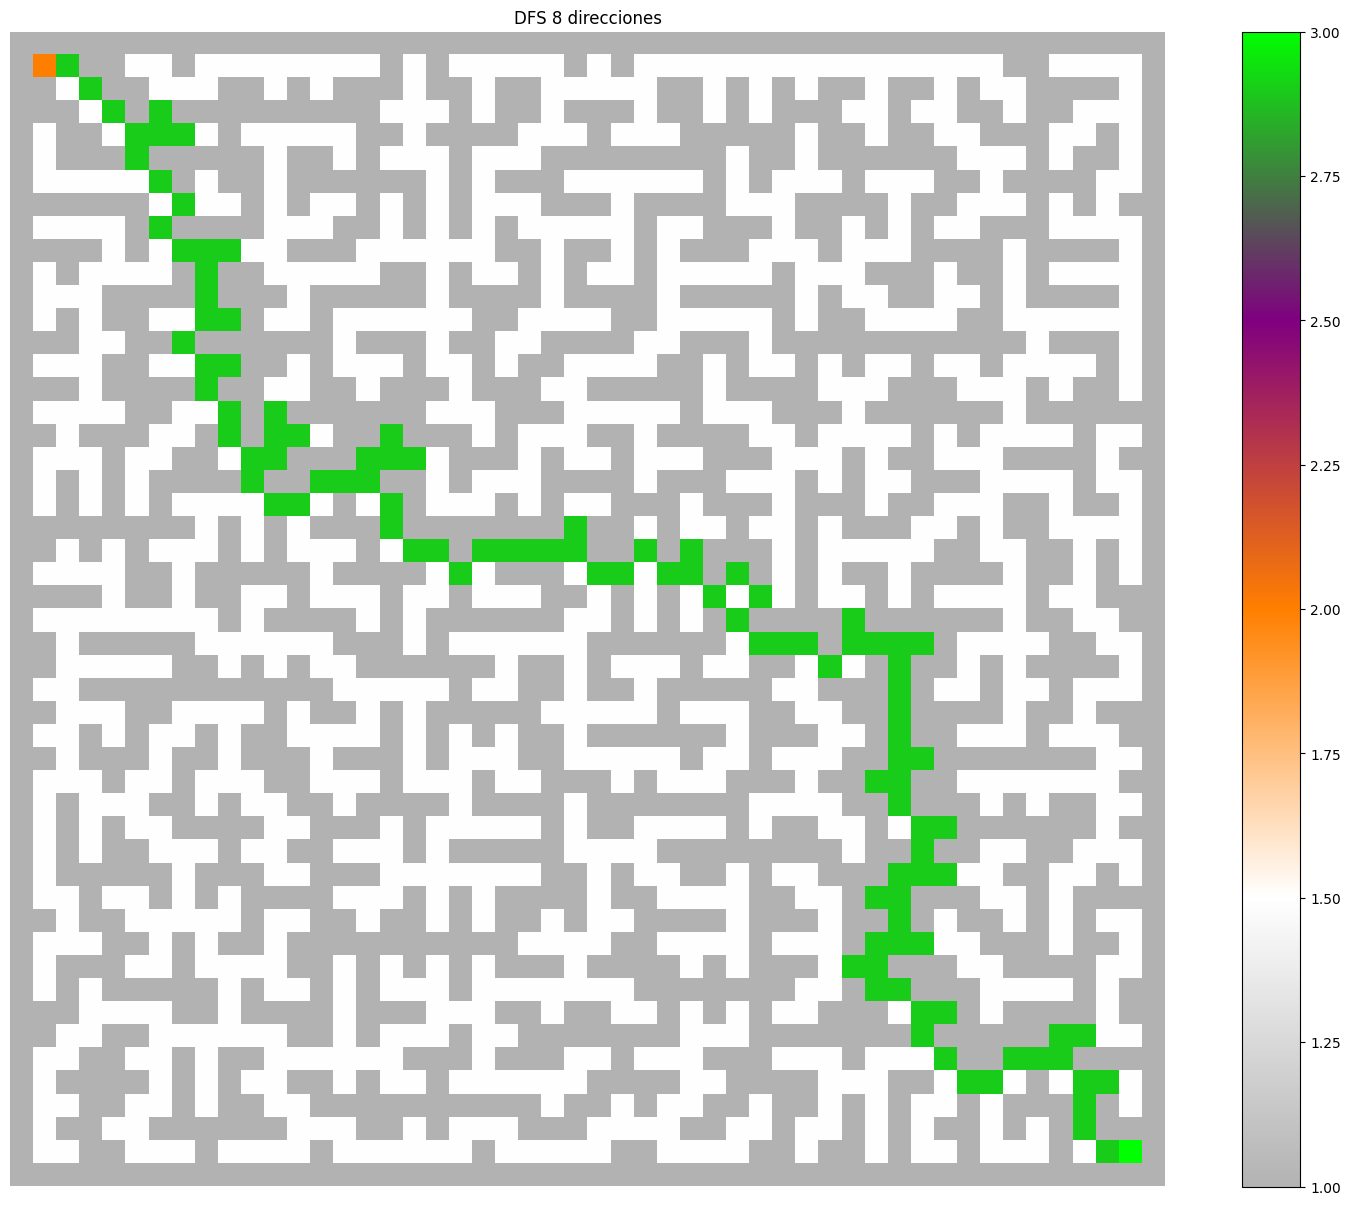

In [19]:
fig, ax = plt.subplots(1,1, figsize=(fig_width,fig_height))
visualize_example(mark_solution,ax,'DFS 8 direcciones', True)